# Test analysis

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl


In [292]:
import os

class Dataset:
    def __init__(self, name: str, path: str, max_iterations: int = 15):
        self.path = path
        self.name = name
        self.data = {}
        self.max_iterations = max_iterations

        file_template = 'test_cases_iter_{number}_results.csv'

        # For every csv file in the path, read it and store it in self.data
        for file in os.listdir(path):
            if file.endswith('.csv') and any(
                file_template.format(number=i) in file for i in range(max_iterations)
            ):
                full_path = os.path.join(path, file)
                self.data[file] = pl.read_csv(full_path)

    def get_data_by_iteration(self, iteration: int):
        # Return the dataframe for the specified iteration
        file_name = f'test_cases_iter_{iteration}_results.csv'
        if file_name in self.data:
            return self.data[file_name]
        else:
            raise ValueError(f"No data found for iteration {iteration}")
        
    def get_merged_real_test_cases_weakness_count(self):
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' in merged_data.columns:
            return merged_data['Test Case Weakness'].value_counts()
        else:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
    
    def get_accuracies_by_weakness(self, relaxed: bool = False):
        # Return a dictionary with accuracies for each weakness
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' not in merged_data.columns:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
        
        weaknesses = merged_data['Test Case Weakness'].unique().to_list()
        accuracies = {}
        
        for weakness in weaknesses:
            df = merged_data.filter(pl.col('Test Case Weakness') == weakness)
            if relaxed:
                accuracies[weakness] = (sum(df['LLM Hit CWE']) * 100) / len(df)
            else:
                accuracies[weakness] = (sum(df['LLM Hit Code']) * 100) / len(df)
        
        return accuracies
    
    def get_accuracy_by_iteration(self, iteration: int, relaxed: bool = False):
        # Return the accuracy for the specified iteration
        df = self.get_data_by_iteration(iteration)
        if relaxed:
            return (sum(df['LLM Hit CWE']) * 100) / len(df)
        else:
            return (sum(df['LLM Hit Code']) * 100) / len(df)
    
    def get_accuracies_by_iterations(self, relaxed: bool = False):
        # Return a dictionary with accuracies for all iterations
        accuracies = []
        for i in range(self.max_iterations):
            try:
                accuracies.append(self.get_accuracy_by_iteration(i, relaxed))
            except ValueError:
                raise ValueError(f"No data found for iteration {i}")
        return accuracies

    def get_merged_accuracy(self, relaxed: bool = False):
        # Merge all dataframes and calculate accuracy
        merged_data = self.get_merged_data()
        if relaxed:
            return (sum(merged_data['LLM Hit CWE']) * 100) / len(merged_data)
        else:
            return (sum(merged_data['LLM Hit Code']) * 100) / len(merged_data)
        
    def get_merged_data(self):
        # Merge all dataframes in self.data into a single dataframe
        merged_data = pl.concat(list(self.data.values()), how='vertical')
        return merged_data
    
class DatasetCollection:
    def __init__(self, datasets: list[Dataset]):
        self.datasets = {}
        for dataset in datasets:
            self.add_dataset(dataset)

    def add_dataset(self, dataset: Dataset):
        self.datasets[dataset.name] = dataset

    def get_dataset(self, name: str) -> Dataset:
        if name in self.datasets:
            return self.datasets[name]
        else:
            raise ValueError(f"Dataset '{name}' not found")
        
    def get_merged_data(self):
        # Merge all datasets into a single dataframe
        merged_data = pl.concat([dataset.get_merged_data() for dataset in self.datasets.values()], how='vertical')
        return merged_data
    
    def get_merged_data_per_iteration(self, iteration: int):
        iterations_data = {}
        for dataset in self.datasets.values():
            dataset_data = dataset.get_data_by_iteration(iteration)
            iterations_data[dataset.name] = dataset_data

        # Merge all datasets for the specified iteration
        merged_data = pl.concat(list(iterations_data.values()), how='vertical')
        return merged_data
    
    def get_merged_per_iteration_accuracies(self, relaxed: bool = False):
        accuracies = []
        # Get merged data and calculate accuracies per iteration
        for iteration in range(self.datasets[list(self.datasets.keys())[0]].max_iterations):
            iterations_data = self.get_merged_data_per_iteration(iteration)
            if relaxed:
                accuracies.append((sum(iterations_data['LLM Hit CWE']) * 100) / len(iterations_data))
            else:
                accuracies.append((sum(iterations_data['LLM Hit Code']) * 100) / len(iterations_data))
        return accuracies

    def get_merged_per_weakness_accuracy(self, relaxed: bool = False):
        # Get merged data and calculate accuracy per weakness
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' not in merged_data.columns:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
        
        weaknesses = merged_data['Test Case Weakness'].unique().to_list()
        accuracies = {}
        
        for weakness in weaknesses:
            df = merged_data.filter(pl.col('Test Case Weakness') == weakness)
            if relaxed:
                accuracies[weakness] = (sum(df['LLM Hit CWE']) * 100) / len(df)
            else:
                accuracies[weakness] = (sum(df['LLM Hit Code']) * 100) / len(df)
        
        return accuracies
    
    def get_merged_real_test_cases_weakness_count(self):
        # Get merged data and count weaknesses
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' in merged_data.columns:
            return merged_data['Test Case Weakness'].value_counts()
        else:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
    
    def get_merged_accuracy(self, relaxed: bool = False):
        # Merge all datasets and calculate accuracy
        merged_data = self.get_merged_data()
        if relaxed:
            return (sum(merged_data['LLM Hit CWE']) * 100) / len(merged_data)
        else:
            return (sum(merged_data['LLM Hit Code']) * 100) / len(merged_data)

In [293]:
csharp_data = Dataset(
    'C#',
    'results/csharp',
    max_iterations=11
)

php_data = Dataset(
    'PHP',
    'results/php',
    max_iterations=11
)

all_datasets = DatasetCollection(
    datasets=[csharp_data, php_data]
)

In [294]:
all_data = [csharp_data, php_data]

# Weaknesses

In [295]:
csharp_data.get_merged_real_test_cases_weakness_count()

Test Case Weakness,count
str,u32
"""CWE-90""",78
"""CWE-78""",86
"""CWE-89""",697
"""CWE-91""",153
"""CWE-22""",86


In [296]:
php_data.get_merged_real_test_cases_weakness_count()

Test Case Weakness,count
str,u32
"""CWE-91""",145
"""CWE-79""",490
"""CWE-89""",140
"""CWE-90""",262
"""CWE-78""",63


In [297]:
all_datasets.get_merged_real_test_cases_weakness_count()

Test Case Weakness,count
str,u32
"""CWE-79""",490
"""CWE-78""",149
"""CWE-90""",340
"""CWE-91""",298
"""CWE-89""",837
"""CWE-22""",86


In [298]:
csharp_data.get_accuracies_by_weakness()

{'CWE-22': 75.5813953488372,
 'CWE-90': 100.0,
 'CWE-78': 100.0,
 'CWE-89': 99.4261119081779,
 'CWE-91': 9.803921568627452}

In [299]:
php_data.get_accuracies_by_weakness()

{'CWE-89': 32.857142857142854,
 'CWE-78': 85.71428571428571,
 'CWE-91': 40.689655172413794,
 'CWE-79': 97.75510204081633,
 'CWE-90': 73.2824427480916}

In [300]:
all_datasets.get_merged_per_weakness_accuracy()

{'CWE-22': 75.5813953488372,
 'CWE-89': 88.2915173237754,
 'CWE-91': 24.83221476510067,
 'CWE-79': 97.75510204081633,
 'CWE-78': 93.95973154362416,
 'CWE-90': 79.41176470588235}

# Real accuracy

In [ ]:
def collect_accuracies(datasets, relaxed=False):
    records = []
    for dataset in datasets:
        for i in range(len(dataset.data)):
            try:
                acc = float(dataset.get_accuracy_by_iteration(i, relaxed=relaxed))
                records.append({
                    "Dataset": dataset.name,
                    "Iteration": i,
                    "Accuracy": acc
                })
            except Exception:
                continue
    return pl.DataFrame(records)

def collect_accuracies_general(datasets: DatasetCollection, relaxed=False):
    records = []
    accuracies = datasets.get_merged_per_iteration_accuracies(relaxed=relaxed)
    for i, acc in enumerate(accuracies):
        records.append({
            "Dataset": "General",
            "Iteration": i,
            "Accuracy": acc
        })
    return pl.DataFrame(records)

def plot_real_accuray(datasets: list[Dataset]):
    df = collect_accuracies(datasets, relaxed=False)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("Accuracy Distribution by Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_real_accuracy_general(datasets: DatasetCollection):
    df = collect_accuracies_general(datasets, relaxed=False)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("General Accuracy Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_relaxed_accuracy(datasets: list[Dataset]):
    df = collect_accuracies(datasets, relaxed=True)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("Relaxed Accuracy Distribution by Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_relaxed_accuracy_general(datasets: DatasetCollection):
    df = collect_accuracies_general(datasets, relaxed=True)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("General Relaxed Accuracy Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_45565/3922881730.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")


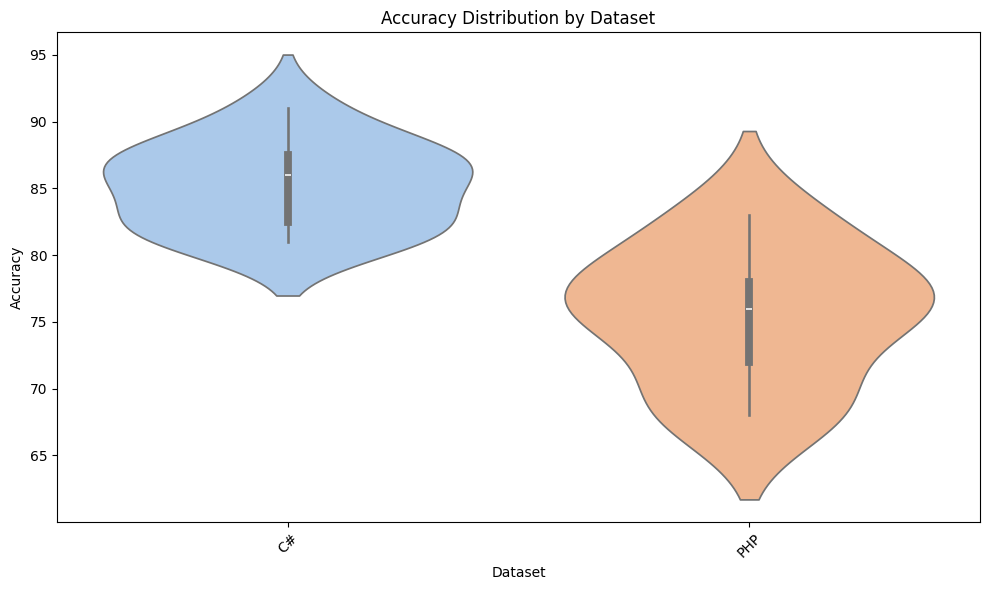

In [302]:
plot_real_accuray(all_data)

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_45565/3922881730.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")


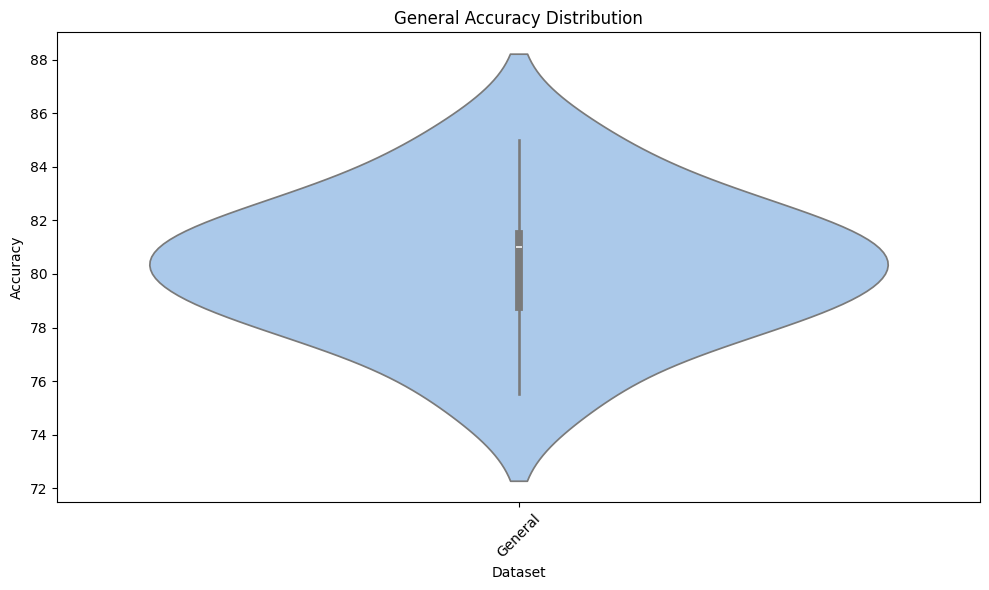

In [303]:
plot_real_accuracy_general(all_datasets)

# Relaxed Accuracy

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_45565/3922881730.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")


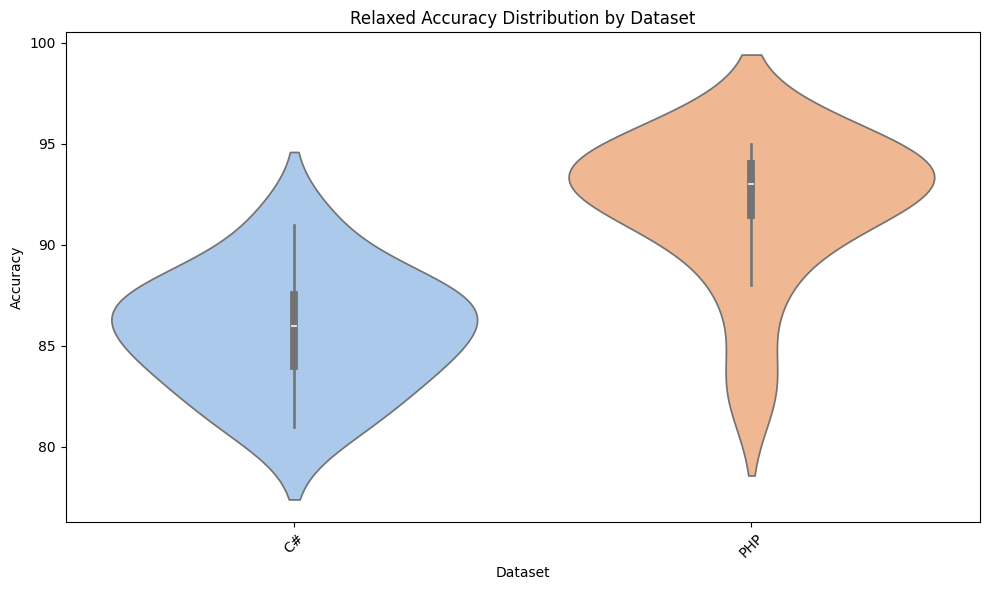

In [304]:
plot_relaxed_accuracy(all_data)

# Tests

In [305]:
from scipy.stats import shapiro, levene, ttest_ind

def do_shapiro(dataset: Dataset):
    # Shapiro-Wilk Test: H0 = data is normally distributed
    accuracies = dataset.get_accuracies_by_iterations(relaxed=False)
    stat, p_value = shapiro(accuracies)

    print("==========================")
    print(f"Shapiro-Wilk Test for {dataset.name}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print(f"Fail to reject H₀: Data appears normally distributed (p > 0.05)")
    else:
        print(f"Reject H₀: Data is not normally distributed (p ≤ 0.05)")
    print("==========================\n")


def do_levene(dataset_1: Dataset, dataset_2: Dataset):
    # Levene's Test: H0 = both groups have equal variances
    acc1 = dataset_1.get_accuracies_by_iterations(relaxed=False)
    acc2 = dataset_2.get_accuracies_by_iterations(relaxed=False)
    
    stat, p_value = levene(acc1, acc2)

    print("==========================")
    print(f"Levene's Test between {dataset_1.name} and {dataset_2.name}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print("Fail to reject H₀: Variances are equal (p > 0.05)")
    else:
        print("Reject H₀: Variances are significantly different (p ≤ 0.05)")
    print("==========================\n")


def do_ttest(dataset1: Dataset, dataset2: Dataset, equal_var: bool = True):
    # Independent t-test: H0 = means are equal
    acc1 = dataset1.get_accuracies_by_iterations(relaxed=False)
    acc2 = dataset2.get_accuracies_by_iterations(relaxed=False)
    
    stat, p_value = ttest_ind(acc1, acc2, equal_var=equal_var)

    print("==========================")
    print(f"T-test between {dataset1.name} and {dataset2.name}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print("Fail to reject H₀: No significant difference in means (p > 0.05)")
    else:
        print("Reject H₀: Significant difference in means (p ≤ 0.05)")
    print("==========================\n")

In [306]:
do_shapiro(csharp_data)
do_shapiro(php_data)

Shapiro-Wilk Test for C#:
Statistic=0.9447, p-value=0.5767
Fail to reject H₀: Data appears normally distributed (p > 0.05)

Shapiro-Wilk Test for PHP:
Statistic=0.9277, p-value=0.3878
Fail to reject H₀: Data appears normally distributed (p > 0.05)



In [307]:
do_levene(csharp_data, php_data)

Levene's Test between C# and PHP:
Statistic=1.1118, p-value=0.3043
Fail to reject H₀: Variances are equal (p > 0.05)



In [308]:
do_ttest(csharp_data, php_data, equal_var=True)

T-test between C# and PHP:
Statistic=5.3447, p-value=0.0000
Reject H₀: Significant difference in means (p ≤ 0.05)

